## Yandex Cloud

Облако Yandex Cloud содержит множество сервисов для выполнения базовых операций. Ниже мы приведём несколько "строительных блоков" в виде кусочков кода на Python, которые вы сможете использовать в своих проектах, например:

* Распознавание текста на картинке
* Рисование картинки по текстовому запросу с Yandex ART
* Работа с Yandex GPT, чтобы переделать текст:
   - сделать его более вежливым
   - получить краткое содержание текста
   - перевести его на другой язык
   - проверить работу студента
* распознать звук (речь) в текст
* синтезировать речь


Выход ->  <br> V Вход | Текст | Картинка | Речь
-----|-------|----------|------
Текст | Преобразование текста | Рисование картинки (Yandex ART) | Синтез речи (TTS)
Картинка | Распознавание текста (OCR) |  | OCR -> TTS 
Речь | Распознавание речи (STT) | STT -> YandexART | 

Для дальнейшей работы потребуются ключи для доступа к облаку: `folder_id` и `api_key`. Мы будем предполагать, что эти ключи записаны в секретах датасферы:

In [3]:
import os

folder_id  = os.environ['folder_id']
api_key = os.environ['api_key']

print(f"Используем folder_id = {folder_id}")

Используем folder_id = b1gst3c7cskk2big5fqn


### Устанавливаем необходимые библиотеки

Для начала надо установить необходимые библиотеки Python, которые понадобятся нам в работе.

In [20]:
%pip install yandex_chain==0.0.9 yandex-speechkit==1.5.0 telebot==0.0.5

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip


### Использование больших языковых моделей

Большие языковые модели позволяют вам совершать различные манипуляции с текстом. Основное, что может модель - это отвечать на ваши вопросы. Соответственно, формулируя вопросы по-разному, вы можете попросить модель придумать что-то, перевести текст, перефразировать его в более короткой или более вежливой форме, и многое другое.

Для работы с моделью создадим объект `gpt`:

In [12]:
from yandex_chain import YandexGPTModel, YandexLLM

gpt = YandexLLM(folder_id=folder_id, api_key=api_key,model=YandexGPTModel.Pro)

print(gpt.invoke('Привет! Придумай 10 новых слов для приветствия.'))

Вот десять новых слов для приветствия:
1. Доброутро!  
2. Здравия желаю!
3. Здравствуйте-ка!
4. Приветствую!
5. С добрым утром! 
6. Здравствуй-здравствуй!
7. Добро пожаловать в этот день! 
8. Доброй встречи!
9. Утро доброе! 
10. Доброе утро нового дня!


Используем модель для преобразования текста в вежливую подробную форму:

In [5]:
texts = [
    "Мне было лень делать домашку",
    "Я опоздал, потому что проспал"
]

prompt = """Пожалуйста, перепиши текст ниже в тройных обратных кавычках в подробной вежливой 
форме, длиною в несколько предложений, не короче 2000 символов. Вот текст:```{}```"""

for x in texts:
    res = gpt.invoke(prompt.format(x))
    print(f"{x}\n---\n{res}\n---")

Мне было лень делать домашку
---
Мне хотелось бы извиниться за свою лень, которая помешала мне выполнить домашнее задание.
Я очень сожалею о том, что не смог проявить должное усердие и завершить работу в срок. 
Прошу прощения у всех, кто ожидал от меня выполнения задания. Обещаю в дальнейшем прилагать больше усилий для того, чтобы справляться с поставленными задачами своевременно.
---
Я опоздал, потому что проспал
---
Я хотел бы принести свои извинения за опоздание. Причиной моего опоздания стал тот факт, что я не смог проснуться вовремя и в результате потерял некоторое время. Мне очень жаль, что так получилось, и я постараюсь впредь быть более организованным. Надеюсь на ваше понимание.
---


Можем попросить модель сделать что-то более сложное, например, оценить ответ школьника на тесте:

In [7]:
texts = [
    "Млекопитающие — это типа такие животные, у которых есть шерсть и они рожают детёнышей. Ну и кормят их молоком, потому что у них есть молочные железы. Вроде всё.",
    "Млекопитающие — это класс позвоночных животных, характеризующийся наличием молочных желез, которые позволяют самкам кормить потомство. Большинство млекопитающих также обладают шерстью или волосами, теплокровностью и сложной системой дыхания. Они рождают живых детёнышей (за исключением яйцекладущих, таких как утконос и ехидна) и имеют высокоразвитую нервную систему, что обеспечивает сложное поведение и способность к обучению."
]

prompt = """
Мне нужно проверить ответ школьника на тесте по биологии на вопрос "млекопитающие". Тебе нужно оценить 
ответ ниже в тройных обратных кавычках по трем параметрам: полнота ответа (complete), 
стройность и стиль изложения (style) и соответствие теме (topic). Также выстави общую среднюю оценку за ответ (grade). Все
оценки выставляй по шкале от 1 до 5, возможно, с дробном виде.
Прочитай текст в сообщении ниже и верни ответ в формате JSON.
Верни только JSON, не нужно объяснений или другого текста.
Ответ школьника:
```{}```
"""

for x in texts:
    res = gpt.invoke(prompt.format(x))
    print(f"{x}\n---\n{res}\n---")

Млекопитающие — это типа такие животные, у которых есть шерсть и они рожают детёнышей. Ну и кормят их молоком, потому что у них есть молочные железы. Вроде всё.
---
```
{
"complete": 3,
"style": 2,
"topic": 4,
"grade": 3.33
}
```
---
Млекопитающие — это класс позвоночных животных, характеризующийся наличием молочных желез, которые позволяют самкам кормить потомство. Большинство млекопитающих также обладают шерстью или волосами, теплокровностью и сложной системой дыхания. Они рождают живых детёнышей (за исключением яйцекладущих, таких как утконос и ехидна) и имеют высокоразвитую нервную систему, что обеспечивает сложное поведение и способность к обучению.
---
```
{
"complete": 4,
"style": 5,
"topic": 5,
"grade": 4.67
}
```
---


Использованный тут формат JSON позволяет легко преобразовать ответ из текста в данные Python:

In [11]:
import json
import pandas as pd

res = []
for x in texts:
    y = gpt.invoke(prompt.format(x))
    y = json.loads(y.replace('```',''))
    y['answer'] = x
    res.append(y)
    
df = pd.DataFrame(res)
df


,complete,style,topic,grade,answer
0,3,2,1,2.00,"Млекопитающие — это типа такие животные, у кот..."
1,4,5,5,4.67,Млекопитающие — это класс позвоночных животных...


### Классификация текста

Иногда нам бывает нужно понять, к какой категории относится текст, из нескольких заданных. Например:
* Разделение почты на спам и не-спам
* Определение команды чат-боту (узнать погоду, поставить встречу в календаре и т.д.)
* Определение тематики новостей (спорт, технологии и т.д.)

Для работы с классификаторами используют `YandexGPTCLassifier`. Предположим, мы хотим сделать чат-бота - помощника по биологии, со следующими командами:
* Вывести список тем
* Рассказать про млекопитающих
* Рассказать про иерархию видов

Вот возможные команды от пользователя:

In [1]:
sents = [
    "Расскажи про классы и виды",
    "Кто такие млекопитающие?",
    "О чем ты можешь рассказать?",
    "Список тем"
]

Для определения того, какая команда содержится в тексте, используем классификатор:

In [4]:
from yandex_chain import YandexGPTClassifier

labels = ['список тем', 'млекопитающие', 'иерархия']

descr = """
Определи, к какой из следующих команд относится входное предложение:
* Вывести список тем (список тем)
* Рассказать про млекопитающих (млекопитающие)
* Рассказать про иерархию классов и видов в биологии (иерархия)
"""

classifier = YandexGPTClassifier(task_description=descr, labels=labels, folder_id=folder_id, api_key=api_key)

for s in sents:
    res = classifier.invoke(s)
    print(f" + [{classifier.get_top_label(res)}] {s}")

 + [иерархия] Расскажи про классы и виды
 + [млекопитающие] Кто такие млекопитающие?
 + [млекопитающие] О чем ты можешь рассказать?
 + [список тем] Список тем


Чтобы улучшить качество классификатора, можно привести ему примеры предложений с указанными классами. Чем больше таких примеров, и чем они разнообразнее - тем лучше!

In [5]:
samples = [
    {
        "text": "Как классифицируют животных в биологии?",
        "label": "иерархия"
    },
    {
        "text": "Какие животные кормят детенышей молоком?",
        "label" : "млекопитающие"
    },
    {
        "text": "О чем ты можешь рассказать?",
        "label" : "список тем"
    }
]

classifier = YandexGPTClassifier(task_description=descr, labels=labels, 
                                 samples=samples, folder_id=folder_id, api_key=api_key)

for s in sents:
    res = classifier.invoke(s)
    print(f" + [{classifier.get_top_label(res)}] {s}")

 + [иерархия] Расскажи про классы и виды
 + [млекопитающие] Кто такие млекопитающие?
 + [список тем] О чем ты можешь рассказать?
 + [список тем] Список тем


### Другие сервисы Yandex Cloud

Для работы с другими сервисами Yandex Cloud надо использовать специальные протоколы общения - REST. Ниже пара функций, которые помогут нам в дальнейшем вызывать разные функции в облаке:

In [35]:
import requests
import os

def call_api(url, data):
    headers = { "Authorization" : f"Api-Key {api_key}" }
    return requests.post(url, json=data, headers=headers).json()

def call_api_get(url, data):
    headers = { "Authorization" : f"Api-Key {api_key}" }
    return requests.get(url, headers=headers).json()

### YandexART

YandexART - это сеть для рисования картинок. Она работает следующим образом:
* Мы делаем запрос на рисование картинки, передавая текстовое описание того, что мы хотим нарисовать
* В ответ получаем набор букв - идентификатор задачи
* По идентификатору задачи мы можем проверять, готова ли картинка, и скачивать её.

Вот функция для подачи запроса:

In [36]:
def submit_art(prompt):
    res = call_api("https://llm.api.cloud.yandex.net/foundationModels/v1/imageGenerationAsync",
    {
        "modelUri": f"art://{folder_id}/yandex-art/latest",
        "messages": [
          {
            "weight": 1,
            "text": prompt
          }
        ]
    })
    if 'error' in res:
        print(res)
        return None
    return res['id']

id = submit_art('Нарисуй ёжика в тумане')
print(id)

fbvd0ihs6metss2l8mod


Для скачивания картинки используем функцию `check`:

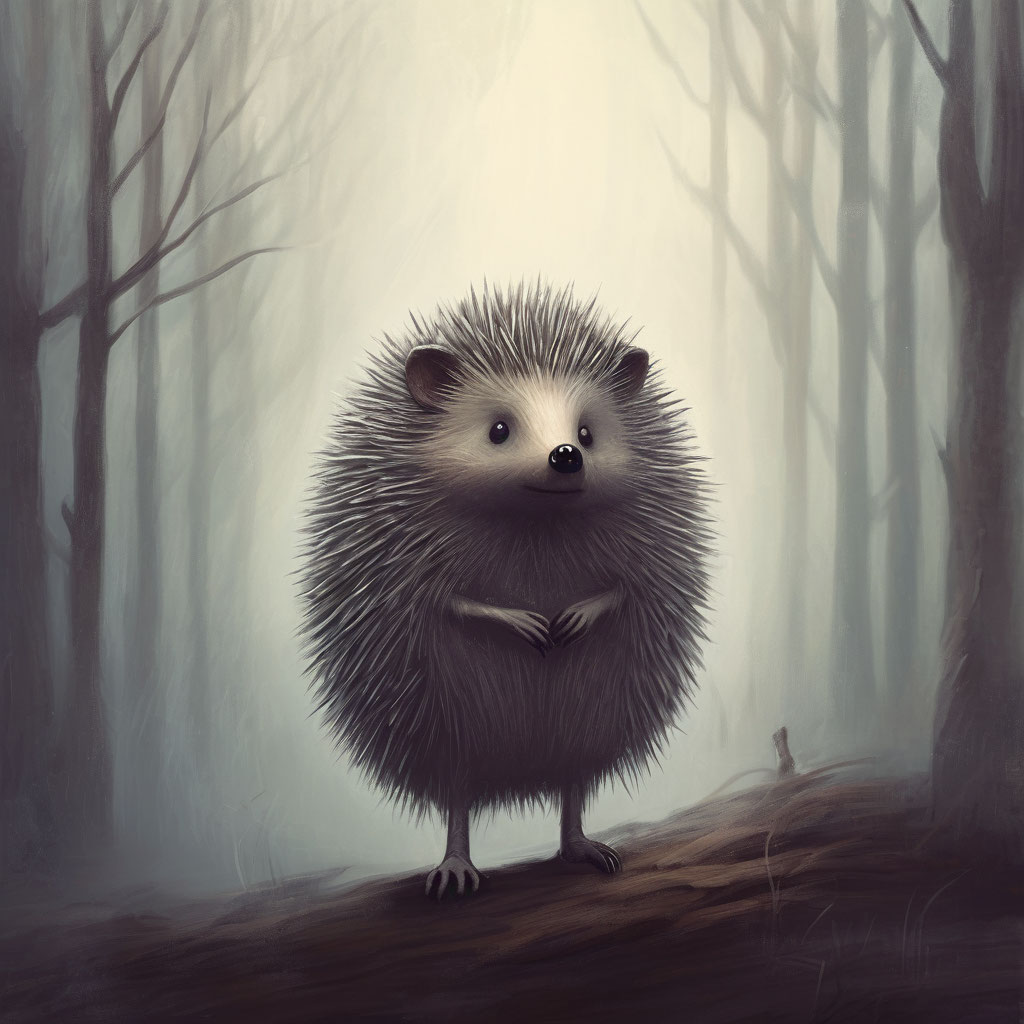

In [37]:
import io
from PIL import Image
import base64

def decode_image(base64_str):
    return Image.open(io.BytesIO(base64.decodebytes(bytes(base64_str, "utf-8"))))

def check(id):
    res = call_api_get(f"https://llm.api.cloud.yandex.net:443/operations/{id}",{})
    if 'done' in res and res['done']:
        return decode_image(res['response']['image'])
    else:
        return None
    
res = check(id)
res

Теперь объединим эти функции вместе и добавим ожидание:

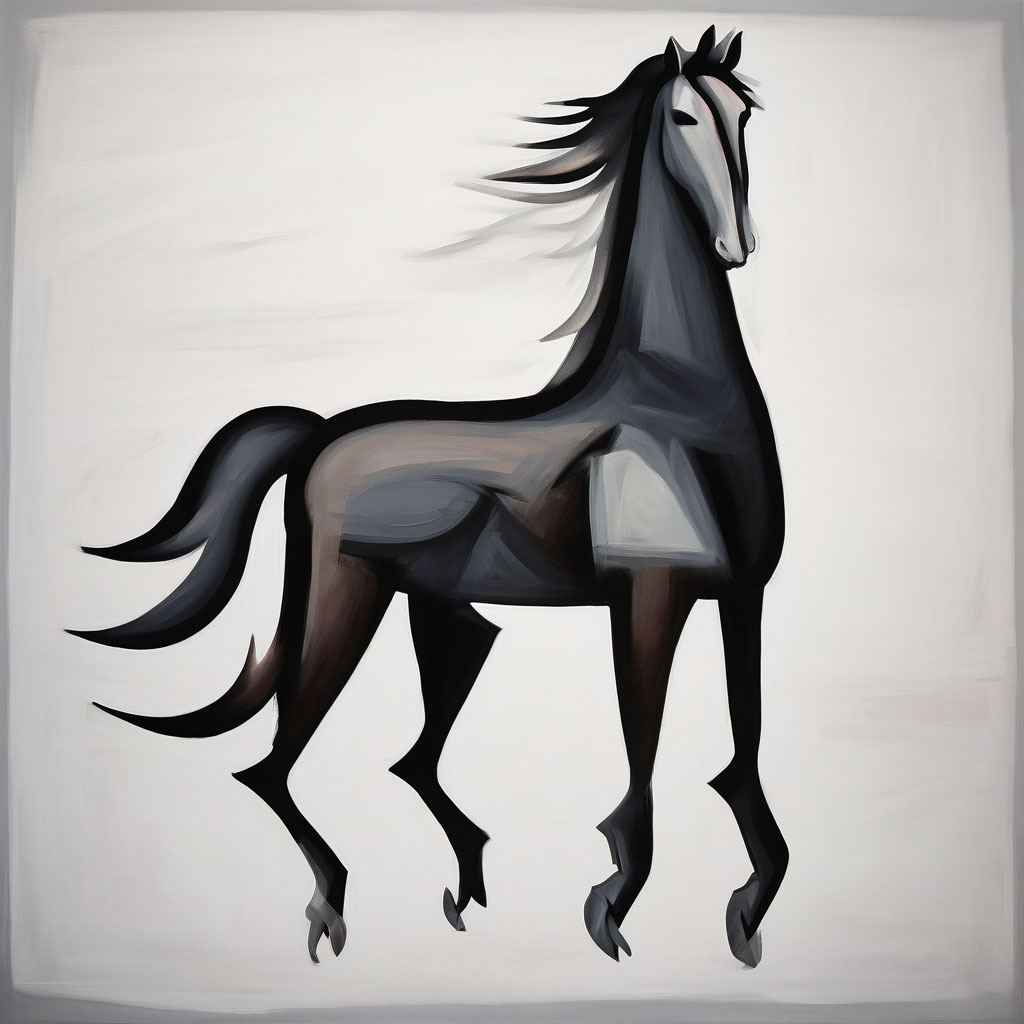

In [38]:
import time

def draw_picture(txt):
    id = submit_art(txt)
    while True:
        time.sleep(10)
        res = check(id)
        if res:
            return res

draw_picture('Лошадка в тумане в стиле Пикассо')

Чуть более сложная функция для рисования сразу нескольких запросов:

In [13]:
def draw_pictures(l):
    d = { x : submit_art(x) for x in l }
    res = {}
    while True:
        time.sleep(10)
        if len(d.keys())==0:
            return res
        for k,v in d.items():
            r = check(v)
            if r:
                res[k] = r
                d[k] = None
        d = { k: v for k,v in d.items() if v is not None }
                
                
draw_pictures(['Ёжик в тумане','Лошадка в тумане'])

{'Ёжик в тумане': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x1024>,
 'Лошадка в тумане': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x1024>}

### Распознаём текст на картинке

Для распознавания текста на картике служит сервис Yandex Vision OCR. Рассмотрим следующую картинку:

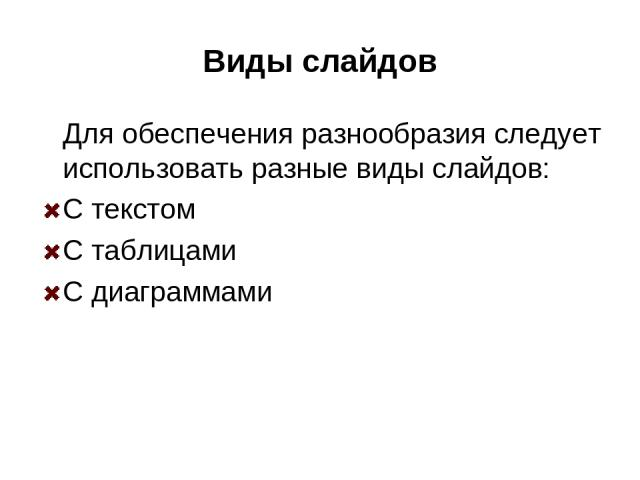

In [33]:
from PIL import Image

img = Image.open('images/slide.jpg')
img

Здесь для работы с картинками мы используем специальную библиотеку Python - PIL. Объект `Image` представляет собой картинку, которую можно считывать и записывать из файла, показывать и т.д.

Функция `ocr` ниже берёт такую картинку и возвращает результат распознавания текстовых объектов на ней:

In [39]:
from io import BytesIO
import base64

def ocr(img):
    buffer = BytesIO()
    img.save(buffer,format="JPEG")
    myimage = buffer.getvalue()

    j = {
      "mimeType": "JPEG",
      "languageCodes": ["*"],
      "model": "page",
      "content": base64.b64encode(myimage).decode('utf-8')
    }
    res = call_api("https://ocr.api.cloud.yandex.net/ocr/v1/recognizeText",j)
    return res

ocr(img)

{'result': {'textAnnotation': {'width': '640',
   'height': '480',
   'blocks': [{'boundingBox': {'vertices': [{'x': '200', 'y': '53'},
       {'x': '200', 'y': '71'},
       {'x': '430', 'y': '71'},
       {'x': '430', 'y': '53'}]},
     'lines': [{'boundingBox': {'vertices': [{'x': '200', 'y': '53'},
         {'x': '200', 'y': '71'},
         {'x': '430', 'y': '71'},
         {'x': '430', 'y': '53'}]},
       'text': 'Виды слайдов',
       'words': [{'boundingBox': {'vertices': [{'x': '200', 'y': '51'},
           {'x': '200', 'y': '75'},
           {'x': '277', 'y': '75'},
           {'x': '277', 'y': '51'}]},
         'text': 'Виды',
         'entityIndex': '-1',
         'textSegments': [{'startIndex': '0', 'length': '4'}]},
        {'boundingBox': {'vertices': [{'x': '294', 'y': '51'},
           {'x': '294', 'y': '75'},
           {'x': '430', 'y': '75'},
           {'x': '430', 'y': '51'}]},
         'text': 'слайдов',
         'entityIndex': '-1',
         'textSegments': [{'s

Чтобы получить только текст, используем такой вариант:

In [40]:
def ocr_text(img):
    res = ocr(img)
    return res['result']['textAnnotation']['fullText']

txt = ocr_text(img)
print(txt)

Виды слайдов
Для обеспечения разнообразия следует
использовать разные виды слайдов:
×С текстом
×С таблицами
×С диаграммами



Теперь этот текст можно подать на вход gpt-модели, чтобы получить более красивый ответ, отформатированный в формате Markdown:

In [28]:
prompt = """Ты - научный редактор. Тебе на вход подаётся текст в тройных обратных кавычках, распознанный 
со слайдов презентации. Пожалуйста, приведи этот текст в аккуратный вид и представь его в формате Markdown.
Текст: ```{}```
"""

res = gpt(prompt.format(txt))
print(res)

### Виды слайдов

Для обеспечения разнообразия следует использовать разные виды слайдов:
* с текстом;
* с таблицами;
* с диаграммами.


### Синтез речи

Для синтеза речи будем использовать специальную библиотеку *Yandex SpeechKit*. Мы опишем функцию, которой можно передать на вход текст, а на выходе получить речь:

In [10]:
from speechkit import model_repository, configure_credentials, creds

# Аутентификация через API-ключ.
configure_credentials(
   yandex_credentials=creds.YandexCredentials(
      api_key=api_key
   )
)

def synthesize(text,voice='jane'):
   model = model_repository.synthesis_model()

   # Задайте настройки синтеза.
   model.voice = voice

   # Синтез речи и создание аудио с результатом.
   result = model.synthesize(text, raw_format=False)
   return result

res = synthesize('Привет, как ты?')
res

Можем скомбинировать синтез с gpt, и получится синтезатор анекдотов:

In [13]:
res = gpt.invoke("Расскажи анекдот про Вовочку")
res = synthesize(res)
res

/home/jupyter/.local/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `BaseLLM.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


С фрагментами речи можно выполнять операцию сложения, чтобы смонтировать целую передачу из анекдотов. Также мы используем разные голоса, чтобы было интереснее слушать.

In [24]:
topics = ['Вовочку','Русского и литовца','Математику']
anecdote_radio = None
for x in topics:
    print(f"Генерирую анекдот про {x}")
    f = synthesize(f'Анекдот про {x}',voice='julia')
    if anecdote_radio:
        anecdote_radio +=f
    else:
        anecdote_radio = f
    f = synthesize(gpt.invoke(f"Расскажи анекдот про {x}"),voice='zahar')
    anecdote_radio += f
    
anecdote_radio

Генерирую анекдот про Вовочку
Генерирую анекдот про Русского и литовца
Генерирую анекдот про Математику


### Распознавание речи

SpeechKit может решать обратную задачу - распознавание речи. Для этого опишем функцию `reco`, и передадим туда сгенерированную нами на прошлом шаге "передачу анекдотов".

In [18]:
from speechkit.stt import AudioProcessingType

def reco(bin):
    model = model_repository.recognition_model()
    model.model = 'general'
    model.language = 'ru-RU'
    model.audio_processing_type = AudioProcessingType.Full
    result = model.transcribe(bin)
    # можно использовать transcribe_file для распознавания файла с речью
    return ' '.join(x.normalized_text for x in result)

reco(anecdote_radio)

'Анекдот про Вовочку, Вовочка, назови 2 местоимения. Кто я анекдот про русского и литовца? К сожалению, я не могу ничего сказать об этом. Давайте сменим тему анекдот про математику. Почему всегда говорят, что математика царица наук? Может, это просто королевство Мавата?'

## Создаём телеграм-бота

Для интерфейса с пользователем удобно использовать телеграм-бота. Первым делом при создании бота нам необходимо создать бота в Telegram, используя специального системного бота **botfather**. Ему нужно дать команду **/newbot**, заполнить ряд полей, и получить в итоге специальный **токен** такого вида:

```
7292776300:AAGeoTIVI4pjNTxuCW7UckKck5G1ZNfFidw
```

Этот токен необходимо записать в секрет DataSphere с именем **tg_token**.

После этого запустите ячейку ниже, описывающую простейшего бота:


In [23]:
import telebot 

telegram_token = os.environ['tg_token']

bot = telebot.TeleBot(telegram_token)

# Обработчик команды /start
@bot.message_handler(commands=['start'])
def start(message):
    # Отправляем приветственное сообщение
    bot.send_message(message.chat.id,
                     'Привет, я бот, как дела?')

# Обработчик для сообщений, содержащих слово "анекдот"
@bot.message_handler(func=lambda message: 'анекдот' in message.text.lower())
def handle_anecdote(message):
    bot.send_message(message.chat.id, f"Вы хотите анекдот? А я их все забыл...")
    
# Обработчик для всех входящих сообщений
@bot.message_handler(func=lambda message: True)
def handle_message(message):
    bot.send_message(message.chat.id, f"Привет, вы сказали {message.text}.")
    
# Запуск бота
bot.polling(none_stop=True)

Ячейка выше будет выполняться бесконечно, пока вы явно её не остановите клавишей "стоп" (квадратик наверху). Пока ячейка работает - ваш бот в Telegram будет окликаться на сообщения. Когда вы останавливате ячейку, или DataSphere выклбчается - бот перестаёт работать. Чтобы он работал всегда - надо использовать более хитрые возможности Yandex Cloud, с которыми мы не будем знакомиться.

Ниже содержится код бота, который умеет принимать и посылать картинки и аудиосообщения. Используйте его в качестве отправной точки для построения своего проекта.

In [44]:
import io
from PIL import Image

bot = telebot.TeleBot(telegram_token)

# Обработчик команды /start
@bot.message_handler(commands=['start'])
def start(message):
    # Отправляем приветственное сообщение
    bot.send_message(message.chat.id,
                     'Привет, я бот, как дела?')

# Обработчик для сообщений, содержащих слово "анекдот"
# В ответ на это бот посылает звуковой файл с анекдотами, который нами был сгенерирован ранее
@bot.message_handler(func=lambda message: 'анекдот' in message.text.lower())
def handle_anecdote(message):
    audio_buffer = io.BytesIO()
    anecdote_radio.export(audio_buffer, format="ogg", codec="libopus")
    audio_buffer.seek(0)
    # Используйте одну из команд ниже для посылки голосового сообщения или аудио-файла
    #bot.send_audio(message.chat.id, audio_buffer)
    bot.send_voice(message.chat.id, audio_buffer)

# Обработчик для сообщений, содержащих слово "нарисуй"
# В ответ на это бот посылает сгенерированную картинку
@bot.message_handler(func=lambda message: 'нарисуй' in message.text.lower())
def handle_anecdote(message):
    img = draw_picture(message.text)
    bot.send_photo(message.chat.id, img)

    
# Обработчик голосовых сообщений
@bot.message_handler(content_types=['voice'])
def handle_voice_message(message):
    # Получаем инфомацию о файле
    voice_file_info = bot.get_file(message.voice.file_id)
    # Скачиваем файл
    downloaded_file = bot.download_file(voice_file_info.file_path)
    res = reco(downloaded_file)
    bot.reply_to(message, f"Получено голосовое сообщение: {res}")

# Обработчик картинок
@bot.message_handler(content_types=['photo'])
def handle_image_message(message):
    highest_res_photo = message.photo[-1]  # Берём вариант фото с макс разрешением
    file_info = bot.get_file(highest_res_photo.file_id)
    # скачиваем файл
    downloaded_file = bot.download_file(file_info.file_path)
    img = Image.open(io.BytesIO(downloaded_file))
    res = ocr_text(img)
    bot.reply_to(message, f"Текст на картинке: {res}")
    
# Обработчик для всех входящих сообщений
@bot.message_handler(func=lambda message: True)
def handle_message(message):
    bot.send_message(message.chat.id, f"Привет, вы сказали {message.text}.")
    
# Запуск бота
print("Бот готов к работе")
bot.polling(none_stop=True)

Бот готов к работе
